#### Задание 

Выберите ряд, на котором происходит аномалия. 
Примените к нему все 4 способа поиска анамолий:

1. Простое мат ожидание. 
2. Потоковые окна. 
3. Кумулятивные суммы. 
4. OneClass SVM.

In [172]:
import matplotlib.pyplot as plt
import numpy as np
from collections import deque
import pandas as pd

from collections import defaultdict
np.random.seed(seed=111111)
np.set_printoptions(precision=3, suppress=True)

import tqdm
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
import statsmodels.tsa.api as smt
from scipy.stats import boxcox
from math import sqrt

import matplotlib.font_manager
from sklearn import svm

In [4]:
sales_of_company_x = pd.read_csv("Series/monthly-sales-of-company-x-jan-6.csv")
robberies_in_boston = pd.read_csv("Series/monthly-boston-armed-robberies-j.csv")
airlines_passengers = pd.read_csv("Series/international-airline-passengers.csv")
mean_monthly_temp = pd.read_csv("Series/mean-monthly-air-temperature-deg.csv")
dowjones_closing = pd.read_csv("Series/weekly-closings-of-the-dowjones-.csv")
female_births = pd.read_csv("Series/daily-total-female-births-in-cal.csv")

In [6]:
all_series = {
    "SC": sales_of_company_x["Count"],
    "BAR": robberies_in_boston["Count"],
    "IAP": airlines_passengers["Count"],
    "AT": mean_monthly_temp["Deg"],
    "CD-JI": dowjones_closing["Close"],
    "TFB": female_births["Count"]
}

In [78]:
def test_stationarity(timeseries):
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for [key, value] in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

In [79]:
def tsplot(y, lags=None, figsize=(14, 8), style='bmh'):
    test_stationarity(y)
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
        
    with plt.style.context(style):
        plt.figure(figsize=figsize)
        layout = (5, 1)
        ts_ax = plt.subplot2grid(layout, (0, 0), rowspan=2)
        acf_ax = plt.subplot2grid(layout, (2, 0))
        pacf_ax = plt.subplot2grid(layout, (3, 0))
        qq_ax = plt.subplot2grid(layout, (4, 0))

        y.plot(ax=ts_ax, color='blue', label='Or')
        ts_ax.axhline(np.quantile(y, 0.80), linestyle='dashed', color='xkcd:dark grey', alpha=0.5, label='max_quantile', 
                   marker='')
        ts_ax.set_title('Original')

        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.05)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.05)
        sm.qqplot(y, line='s', ax=qq_ax)
        
        plt.tight_layout()
    return

Results of Dickey-Fuller Test:
Test Statistic                -1.013163e+01
p-value                        8.886328e-18
#Lags Used                     0.000000e+00
Number of Observations Used    1.640000e+02
Critical Value (1%)           -3.470866e+00
Critical Value (5%)           -2.879330e+00
Critical Value (10%)          -2.576255e+00
dtype: float64


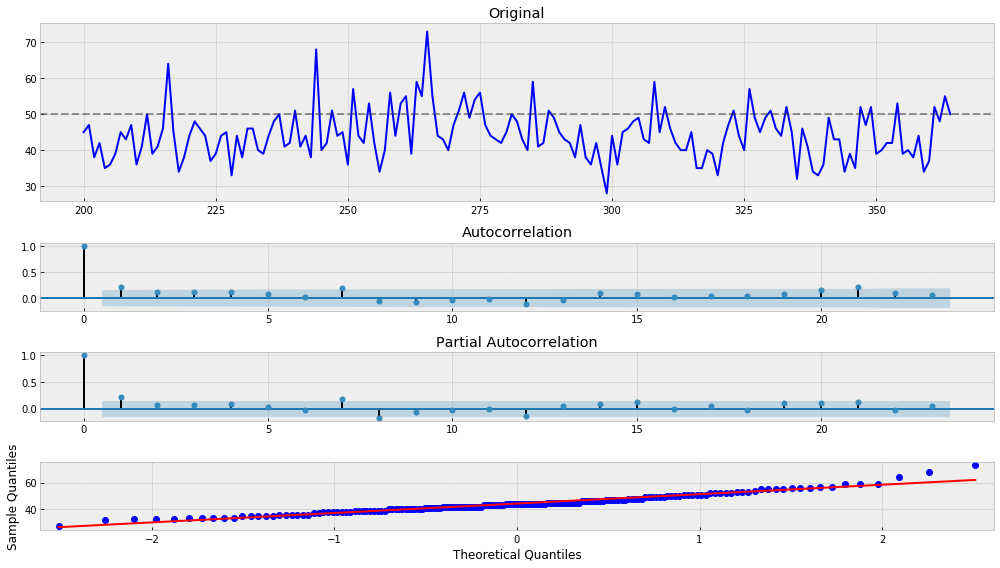

In [143]:
series_1 = all_series["TFB"][200:]
tsplot(series_1)

#### Визуально аномалия временного ряда в периоде: 265-320

## 1. Простое мат ожидание

In [118]:
class MeanDetector:
    def __init__(self, threshold=5):
        self.threshold = threshold
        self.total_val = 0
        self.count = 0
        self.mean = 0
    
    def update(self, new_signal_value):
        self.count += 1
        self.total_val += new_signal_value
        self.mean = self.total_val / self.count
    
    def check(self, new_signal_value): 
        threshold_level = self.mean * self.threshold
        
        if np.abs(new_signal_value - self.mean) > threshold_level:
            return True
        return False

In [119]:
def simulate(detector, signal):
    stop_points = []
    for i, value in enumerate(signal):
        detector.update(value)
        if detector.check(value):
            stop_points.append(i)
    
    plt.figure(figsize=(14,8))
    plt.plot(signal, 'b.')
    plt.plot(signal, 'b-', alpha=0.15)
    plt.title('Signal')
    print(len(stop_points))
    if stop_points:
        plt.vlines(x=stop_points[0], ymin=0, ymax=np.max(signal),
                      colors='r', linestyles='dotted')
    
    plt.show()

0


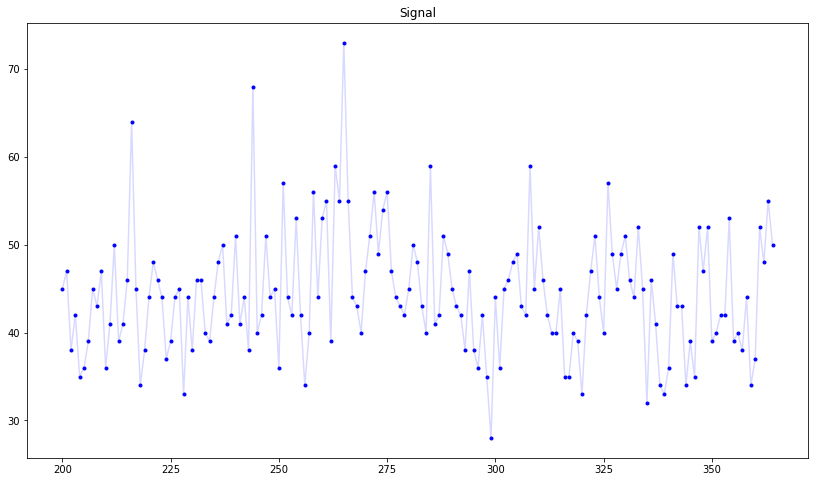

In [144]:
simulate(MeanDetector(), series_1)

## 2. Потоковые окна

In [124]:
class ZScoreDetector:
    def __init__(self, window_size = 100, threshold=0.05):
        self.threshold = threshold
        self.window_size = window_size
        self.k = 0  
        self.g_mean = 0.0  # global mean  
        self.s = 0.0  # for Welford's method. variance = s / (k + 1)
        self.window = deque(maxlen = window_size)
        self.z_score = np.nan
        
    def update(self, new_signal_value):
        x = new_signal_value
        
        # Добавляем в окно
        self.window.append(x)
        
        # Считаем статистики
        oldm = self.g_mean
        newm = oldm + (x - oldm) / (self.k + 1)
        s = self.s + (x - newm) * (x - oldm)
        g_mean = newm 
        g_std = np.sqrt(s / (self.k+1))
        
        # Считаем статистикии по выборке
        w_mean = np.mean(self.window)
        w_std = np.std(self.window)

        # Считаем Z-score
        std_diff = (g_std - w_std) / g_std        
        SE = g_std / np.sqrt(self.window_size)
        mean_diff = (g_mean - w_mean) / g_mean
        self.z_score = (w_mean - g_mean) / SE
        
        # Обновлем атрибуты
        self.g_mean = g_mean
        self.s = s
        
        self.k += 1
    
    def check(self, new_signal_value):
        if np.abs(self.z_score) > self.threshold:
            return True
        return False

0


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in double_scalars
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in double_scalars


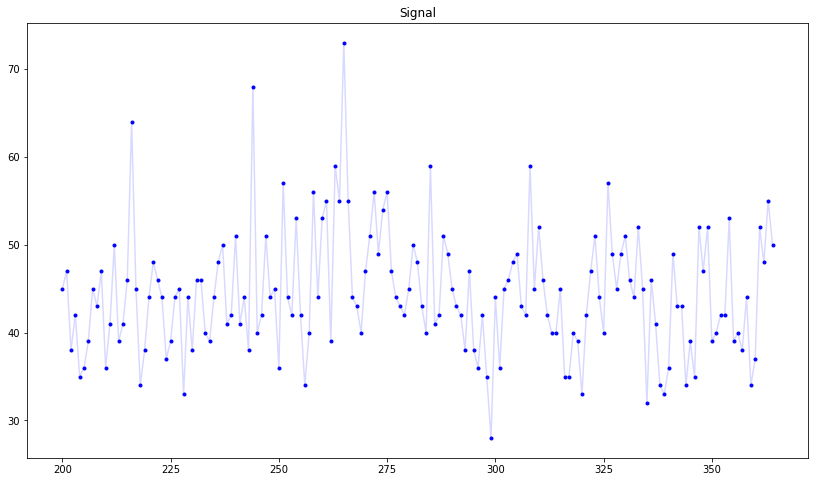

In [145]:
simulate(ZScoreDetector(window_size=80, threshold=5.0), series_1)

## 3. Кумулятивные суммы

In [150]:
__author__ = 'Marcos Duarte, https://github.com/demotu/BMC'
__version__ = "1.0.4"
__license__ = "MIT"

def detect_cusum(x, threshold=1, drift=0, ending=False, show=True, ax=None):
    """Cumulative sum algorithm (CUSUM) to detect abrupt changes in data.

    Parameters
    ----------
    x : 1D array_like
        data.
    threshold : positive number, optional (default = 1)
        amplitude threshold for the change in the data.
    drift : positive number, optional (default = 0)
        drift term that prevents any change in the absence of change.
    ending : bool, optional (default = False)
        True (1) to estimate when the change ends; False (0) otherwise.
    show : bool, optional (default = True)
        True (1) plots data in matplotlib figure, False (0) don't plot.
    ax : a matplotlib.axes.Axes instance, optional (default = None).

    Returns
    -------
    ta : 1D array_like [indi, indf], int
        alarm time (index of when the change was detected).
    tai : 1D array_like, int
        index of when the change started.
    taf : 1D array_like, int
        index of when the change ended (if `ending` is True).
    amp : 1D array_like, float
        amplitude of changes (if `ending` is True).

    Notes
    -----
    Настройка алгоритма CUSUM по Густафссону (2000)[1]_:
    Начните с очень большого `threshold`.
    Выберите `drift` до половины ожидаемого изменения или отрегулируйте `drift` таким образом
    это " g " = 0 более чем в 50% случаев.
    Затем установите `threshold`, чтобы получить необходимое количество ложных срабатываний (это можно
    сделать автоматически) или задержку обнаружения.
    Если требуется более быстрое обнаружение, попробуйте уменьшить `drift`.
    Если требуется меньше ложных тревог, попробуйте увеличить `drift`.
    Если есть подмножество времен изменения, которое не имеет смысла,
    попробуйте увеличить `drift`.

    Обратите внимание, что по умолчанию повторяются последовательные изменения, т. е.
    то же самое начало (`tai`) не удаляется, потому что изменения были
    обнаруживается сигналом тревоги (`та`) в разные моменты времени. Именно так
    работает классический алгоритм CUSUM.

    Если вы хотите удалить повторные последовательные изменения и сохранить только
    начало первого последовательного изменения, установите параметр " окончание` в значение
    Правда. В этом случае индекс окончания изменения (`taf`) и
    амплитуда изменения (или общая амплитуда для повторной
    последовательное изменение) вычисляются и сохраняются только первые изменения повторных
    последовательных изменений. В этом случае вполне вероятно, что `ta`, `tai`
    и `taf` будут иметь меньшие значения, чем когда `ending` был установлен в False.

    См. Этот блокнот IPython [2]_.

    References
    ----------
    .. [1] Gustafsson (2000) Adaptive Filtering and Change Detection.
    .. [2] hhttp://nbviewer.ipython.org/github/demotu/BMC/blob/master/notebooks/DetectCUSUM.ipynb

    """

    x = np.atleast_1d(x).astype('float64')
    gp, gn = np.zeros(x.size), np.zeros(x.size)
    ta, tai, taf = np.array([[], [], []], dtype=int)
    tap, tan = 0, 0
    amp = np.array([])
    # Find changes (online form)
    for i in range(1, x.size):
        s = x[i] - x[i-1]
        gp[i] = gp[i-1] + s - drift  # cumulative sum for + change
        gn[i] = gn[i-1] - s - drift  # cumulative sum for - change
        if gp[i] < 0:
            gp[i], tap = 0, i
        if gn[i] < 0:
            gn[i], tan = 0, i
        if gp[i] > threshold or gn[i] > threshold:  # change detected!
            ta = np.append(ta, i)    # alarm index
            tai = np.append(tai, tap if gp[i] > threshold else tan)  # start
            gp[i], gn[i] = 0, 0      # reset alarm
    # THE CLASSICAL CUSUM ALGORITHM ENDS HERE

    # Estimation of when the change ends (offline form)
    if tai.size and ending:
        _, tai2, _, _ = detect_cusum(x[::-1], threshold, drift, show=False)
        taf = x.size - tai2[::-1] - 1
        # Eliminate repeated changes, changes that have the same beginning
        tai, ind = np.unique(tai, return_index=True)
        ta = ta[ind]
        # taf = np.unique(taf, return_index=False)  # corect later
        if tai.size != taf.size:
            if tai.size < taf.size:
                taf = taf[[np.argmax(taf >= i) for i in ta]]
            else:
                ind = [np.argmax(i >= ta[::-1])-1 for i in taf]
                ta = ta[ind]
                tai = tai[ind]
        # Delete intercalated changes (the ending of the change is after
        # the beginning of the next change)
        ind = taf[:-1] - tai[1:] > 0
        if ind.any():
            ta = ta[~np.append(False, ind)]
            tai = tai[~np.append(False, ind)]
            taf = taf[~np.append(ind, False)]
        # Amplitude of changes
        amp = x[taf] - x[tai]

    if show:
        _plot(x, threshold, drift, ending, ax, ta, tai, taf, gp, gn)

    return ta, tai, taf, amp


def _plot(x, threshold, drift, ending, ax, ta, tai, taf, gp, gn):
    """Plot results of the detect_cusum function, see its help."""

    try:
        import matplotlib.pyplot as plt
    except ImportError:
        print('matplotlib is not available.')
    else:
        if ax is None:
            _, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))

        t = range(x.size)
        ax1.plot(t, x, 'b-', lw=2)
        if len(ta):
            ax1.plot(tai, x[tai], '>', mfc='g', mec='g', ms=10,
                     label='Start')
            if ending:
                ax1.plot(taf, x[taf], '<', mfc='g', mec='g', ms=10,
                         label='Ending')
            ax1.plot(ta, x[ta], 'o', mfc='r', mec='r', mew=1, ms=5,
                     label='Alarm')
            ax1.legend(loc='best', framealpha=.5, numpoints=1)
        ax1.set_xlim(-.01*x.size, x.size*1.01-1)
        ax1.set_xlabel('Data #', fontsize=14)
        ax1.set_ylabel('Amplitude', fontsize=14)
        ymin, ymax = x[np.isfinite(x)].min(), x[np.isfinite(x)].max()
        yrange = ymax - ymin if ymax > ymin else 1
        ax1.set_ylim(ymin - 0.1*yrange, ymax + 0.1*yrange)
        ax1.set_title('Time series and detected changes ' +
                      '(threshold= %.3g, drift= %.3g): N changes = %d'
                      % (threshold, drift, len(tai)))
        ax2.plot(t, gp, 'y-', label='+')
        ax2.plot(t, gn, 'm-', label='-')
        ax2.set_xlim(-.01*x.size, x.size*1.01-1)
        ax2.set_xlabel('Data #', fontsize=14)
        ax2.set_ylim(-0.01*threshold, 1.1*threshold)
        ax2.axhline(threshold, color='r')
        ax1.set_ylabel('Amplitude', fontsize=14)
        ax2.set_title('Time series of the cumulative sums of ' +
                      'positive and negative changes')
        ax2.legend(loc='best', framealpha=.5, numpoints=1)
        plt.tight_layout()
        plt.show()

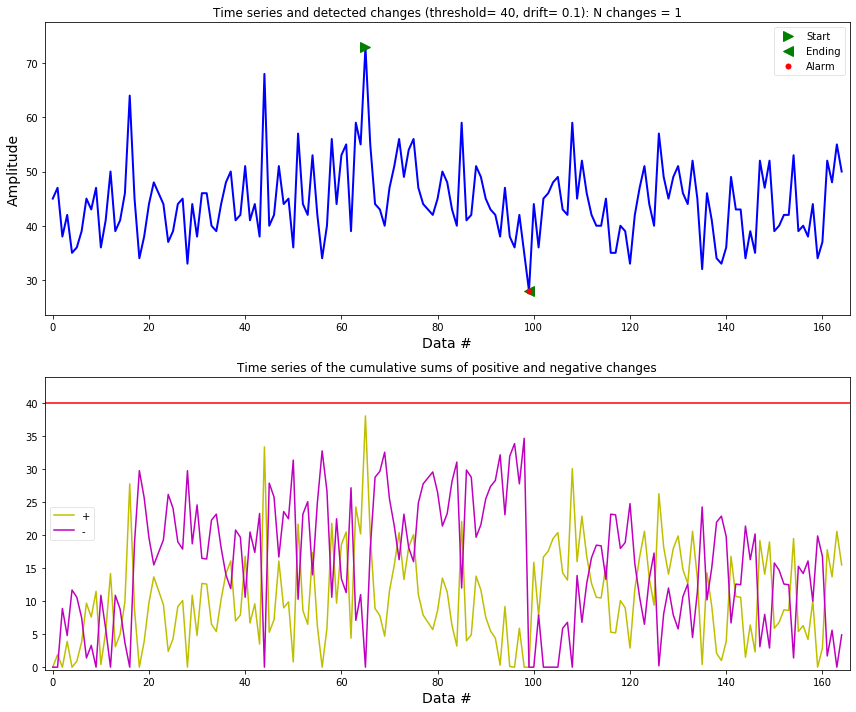

In [170]:
ta, tai, taf, amp = detect_cusum(series_1, 40, .1, True, True)

#### Ура! Определил аномалию, но слишком рано поставил End

## 4. OneClass SVM

In [192]:
series_2 = all_series["TFB"]
series = np.array(series_2).reshape(-1, 1)

In [193]:
len(series)

365

In [290]:
clf = svm.OneClassSVM(nu=0.1, kernel="rbf", gamma=0.01)
clf.fit(series[:150])

y_pred_train = clf.predict(series[:150])
y_pred_test = clf.predict(series[150:])

In [291]:
y = np.linspace(20, 80, 500).reshape(-1, 1)
Z = clf.decision_function(y)
Z = np.vstack((Z, Z))
y = y.reshape(500)

In [292]:
false_positive_train = []
false_positive_test = []
for i, t in enumerate(y_pred_train):
    if t != 1:
        false_positive_train.append((i, series[i]))
        
for i, t in enumerate(y_pred_test):
    if t != 1:
        idx = len(y_pred_train) + i
        false_positive_test.append((idx,series[idx]))

In [293]:
false_positive_train = np.array(false_positive_train)
false_positive_test = np.array(false_positive_test)

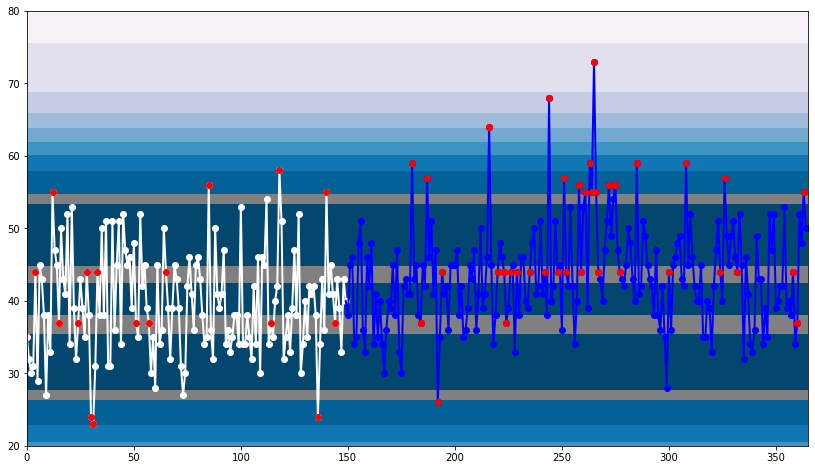

In [294]:
plt.figure(figsize=(14,8))
plt.contourf([0, 365], y, Z.T, cmap=plt.cm.PuBu)
plt.contour([0, 365], y, Z.T, levels=[0], linewidths=10, colors='gray')
plt.plot(range(150), series[:150], 'wo', linewidth=10)
plt.plot(range(150), series[:150], 'w-', linewidth=2)
plt.plot(range(150,365), series[150:], 'bo', linewidth=10)
plt.plot(range(149,365), series[149:], 'b-', linewidth=2)
plt.plot(false_positive_train[:, 0], false_positive_train[:, 1], 'ro')
plt.plot(false_positive_test[:, 0], false_positive_test[:, 1], 'ro')
plt.show()

In [ ]:
## Аномалию и выбросы определил, но не учел выброс на 300 и другой характер ряда с периоде 275-320